## Accès à la base de données sur la délinquance depuis une API et importation du DataFrame

On récupère les données sur la délinquance depuis le site https://www.data.gouv.fr/fr/datasets/bases-statistiques-communale-departementale-et-regionale-de-la-delinquance-enregistree-par-la-police-et-la-gendarmerie-nationales/. 

Pour accéder aux données des **arrondissements de Paris**, on choisit la base communale, et on applique un filtre pour ne sélectionner que les codes des arrondissements de Paris. 


In [165]:
import requests
import pandas as pd

api_root_delinquance = "https://tabular-api.data.gouv.fr/api/resources/"
ID_delinquance = "3f51212c-f7d2-4aec-b899-06be6cdd1030"
filtre = "?CODGEO_2024__greater=75101&CODGEO_2024__less=75120." # Filtre pour ne sélectionner que les arrondissements de Paris 
url_api_delinquance = api_root_delinquance + ID_delinquance + "/data/" + filtre 

print(url_api_delinquance)

def recuperation_data(url_api):
    df = []  
    current_url = url_api

    while current_url:
        req = requests.get(current_url)
        wb = req.json()
        df.extend(wb['data'])
        current_url = wb["links"].get("next")
    return pd.DataFrame(df)

df_delinquance = recuperation_data(url_api_delinquance)
df_delinquance.head() 

https://tabular-api.data.gouv.fr/api/resources/3f51212c-f7d2-4aec-b899-06be6cdd1030/data/?CODGEO_2024__greater=75101&CODGEO_2024__less=75120.


,__id,CODGEO_2024,annee,classe,unité.de.compte,valeur.publiée,faits,tauxpourmille,complementinfoval,complementinfotaux,POP,millPOP,LOG,millLOG
0,409781,75101,16,Coups et blessures volontaires,victime,diff,271.0,"1,66748707851341e+01",NaN,NaN,16252,16,"1,37973242421027e+04",16
1,409782,75101,16,Coups et blessures volontaires intrafamiliaux,victime,diff,33.0,"2,03051932069899e+00",NaN,NaN,16252,16,"1,37973242421027e+04",16
2,409783,75101,16,Autres coups et blessures volontaires,victime,diff,238.0,"1,46443514644351e+01",NaN,NaN,16252,16,"1,37973242421027e+04",16
3,409784,75101,16,Violences sexuelles,victime,diff,93.0,"5,72237263106079e+00",NaN,NaN,16252,16,"1,37973242421027e+04",16
4,409785,75101,16,Vols avec armes,infraction,diff,28.0,"1,72286487816884e+00",NaN,NaN,16252,16,"1,37973242421027e+04",16


In [167]:
df_delinquance= df_delinquance.rename(columns={"CODGEO_2024": "INSEE_COG"})
df_delinquance['arrondissement'] = df_delinquance['INSEE_COG'].astype(str).str[-2:]

df_delinquance['tauxpourmille'] = df_delinquance['tauxpourmille'].str.replace(',', '.', regex=False)
df_delinquance['tauxpourmille'] = df_delinquance['tauxpourmille'].str.replace('+', '', regex=False)  
df_delinquance['tauxpourmille'] = pd.to_numeric(df_delinquance['tauxpourmille'], errors='coerce')


AttributeError: Can only use .str accessor with string values!

In [168]:
df_delinquance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   __id                2240 non-null   int64  
 1   INSEE_COG           2240 non-null   object 
 2   annee               2240 non-null   int64  
 3   classe              2240 non-null   object 
 4   unité.de.compte     2240 non-null   object 
 5   valeur.publiée      2240 non-null   object 
 6   faits               2228 non-null   float64
 7   tauxpourmille       2228 non-null   float64
 8   complementinfoval   12 non-null     float64
 9   complementinfotaux  12 non-null     float64
 10  POP                 2240 non-null   int64  
 11  millPOP             2240 non-null   int64  
 12  LOG                 2240 non-null   object 
 13  millLOG             2240 non-null   int64  
 14  arrondissement      2240 non-null   object 
dtypes: float64(4), int64(5), object(6)
memory usage: 262.6+

## Sélection des types de délinquance


In [170]:
valeurs_uniques = df_delinquance['classe'].unique()
print("Types de crimes :")
print(valeurs_uniques)

Types de crimes :
['Coups et blessures volontaires'
 'Coups et blessures volontaires intrafamiliaux'
 'Autres coups et blessures volontaires' 'Violences sexuelles'
 'Vols avec armes' 'Vols violents sans arme'
 'Vols sans violence contre des personnes' 'Cambriolages de logement'
 'Vols de véhicules' 'Vols dans les véhicules'
 "Vols d'accessoires sur véhicules"
 'Destructions et dégradations volontaires' 'Trafic de stupéfiants'
 'Usage de stupéfiants']


Étant donné le sujet de notre étude, nous excluons les types de crimes qui ne nous semblent pas pertinents, notamment les "coups et blessures volontaires intrafamiliaux".

In [171]:
df_delinquance = df_delinquance[df_delinquance['classe'] != 'Coups et blessures volontaires intrafamiliaux']

# Statistiques descriptives

Afin de visualiser la situation de la délinquance à Paris, nous allons calculer le nombre moyen annuel de faits de délinquance pour mille habitants dans chaque arrondissement, pour les années 2016 à 2023. 

In [173]:
# Groupement par arrondissement et année, et somme des faits de délinquance
# La variable "tauxpourmille" donne le nombre de faits de délinquance pour mille habitants 
delinquance_par_arrondissement = df_delinquance.groupby(['arrondissement', 'annee'], as_index=False)['tauxpourmille'].sum()

# Calcul d'une moyenne annuelle par arrondissement
delinquance_par_arrondissement = delinquance_par_arrondissement.groupby('arrondissement', as_index=False)['tauxpourmille'].mean()  # Moyenne annuelle par arrondissement

delinquance_par_arrondissement.rename(columns={'tauxpourmille': 'moyenne_annuelle'}, inplace=True)
delinquance_par_arrondissement

,arrondissement,moyenne_annuelle
0,01,649.525040
1,02,268.275110
2,03,164.083016
3,04,223.701993
4,05,114.030621
5,06,146.365548
6,07,122.549336
7,08,385.206936
8,09,210.746011
9,10,204.109959


### Visualisation du nombre de faits de délinquance par arrondissement 

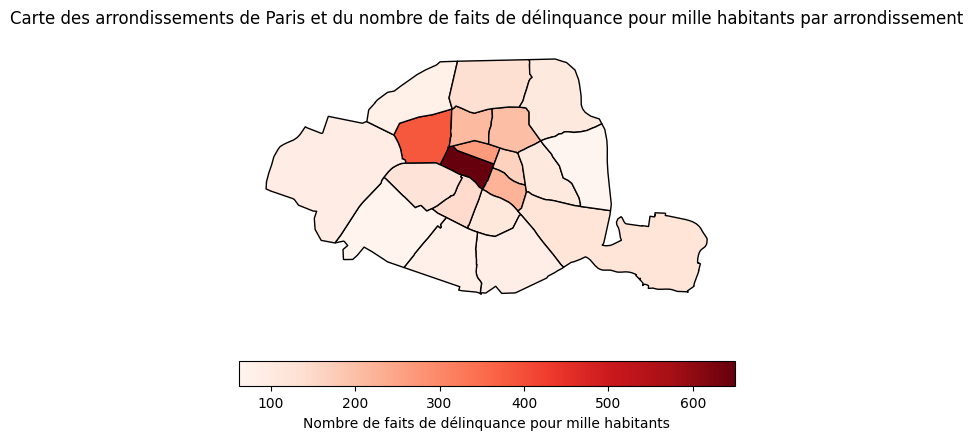

In [174]:
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download

# Importation de la carte des arrondissements de Paris
arr_borders = carti_download(
    crs=4326,
    values=["75"],
    borders="COMMUNE_ARRONDISSEMENT",
    vectorfile_format="geojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

arr_borders = arr_borders.to_crs(2154)  

arr_borders['arrondissement'] = arr_borders['INSEE_COG'].str[-2:]  
arr_borders_sorted = arr_borders.sort_values(by='arrondissement')
arr_borders_sorted['moyenne_annuelle'] = delinquance_par_arrondissement['moyenne_annuelle'].values

carte = arr_borders_sorted.plot(
    column="moyenne_annuelle",  
    cmap="Reds",        
    legend=True,             
    edgecolor="black",       
    legend_kwds={"label": "Nombre de faits de délinquance pour mille habitants", "orientation": "horizontal"},
)

carte.set_axis_off()  
carte.set_title("Carte des arrondissements de Paris et du nombre de faits de délinquance pour mille habitants par arrondissement")

plt.show()

Cette carte offre une représentation visuelle des niveaux de délinquance par arrondissement à Paris, mesurés en fonction du nombre de faits pour mille habitants. Elle met en évidence une disparité notable entre les arrondissements centraux et périphériques. Les arrondissements centraux, tels que le 1er, le 2e, mais aussi le 8e se distinguent par des niveaux de délinquance significativement plus élevés, comme le montre l'intensité des teintes rouges. Tandis que les arrondissements périphériques présentent des niveaux de délinquance nettement inférieurs, symbolisés par des teintes plus claires. 

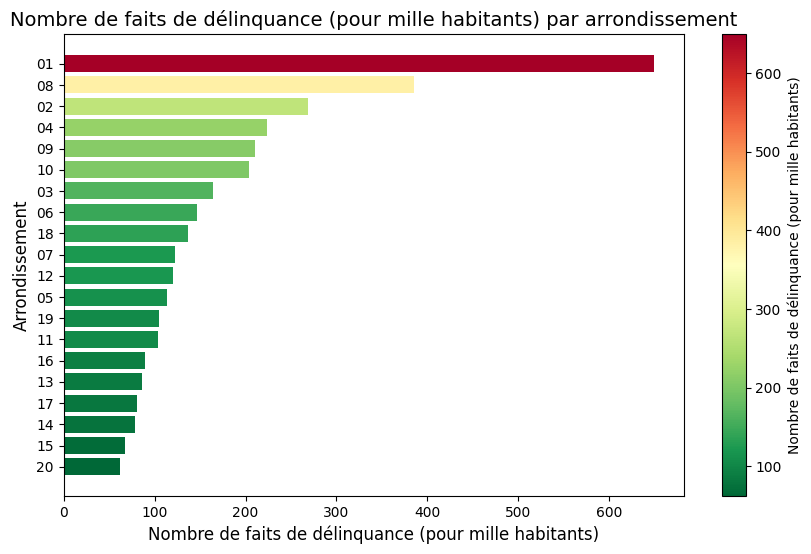

In [175]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Tri des données par moyenne annuelle 
delinquance_sorted = delinquance_par_arrondissement.sort_values(by='moyenne_annuelle')
norm = mcolors.Normalize(vmin=delinquance_sorted['moyenne_annuelle'].min(), 
                         vmax=delinquance_sorted['moyenne_annuelle'].max())
cmap = cm.RdYlGn_r

# Création du graphique
fig, ax = plt.subplots(figsize=(10, 6))
plt.barh(
    delinquance_sorted['arrondissement'], 
    delinquance_sorted['moyenne_annuelle'], 
    color=[cmap(norm(value)) for value in delinquance_sorted['moyenne_annuelle']]
)

plt.xlabel("Nombre de faits de délinquance (pour mille habitants)", fontsize=12)
plt.ylabel("Arrondissement", fontsize=12)
plt.title("Nombre de faits de délinquance (pour mille habitants) par arrondissement", fontsize=14)

# Ajout de la barre de couleur
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
fig.colorbar(sm, ax=ax, orientation='vertical', label="Nombre de faits de délinquance (pour mille habitants)")

plt.show()


### Distribution des types de délinquance par arrondissement

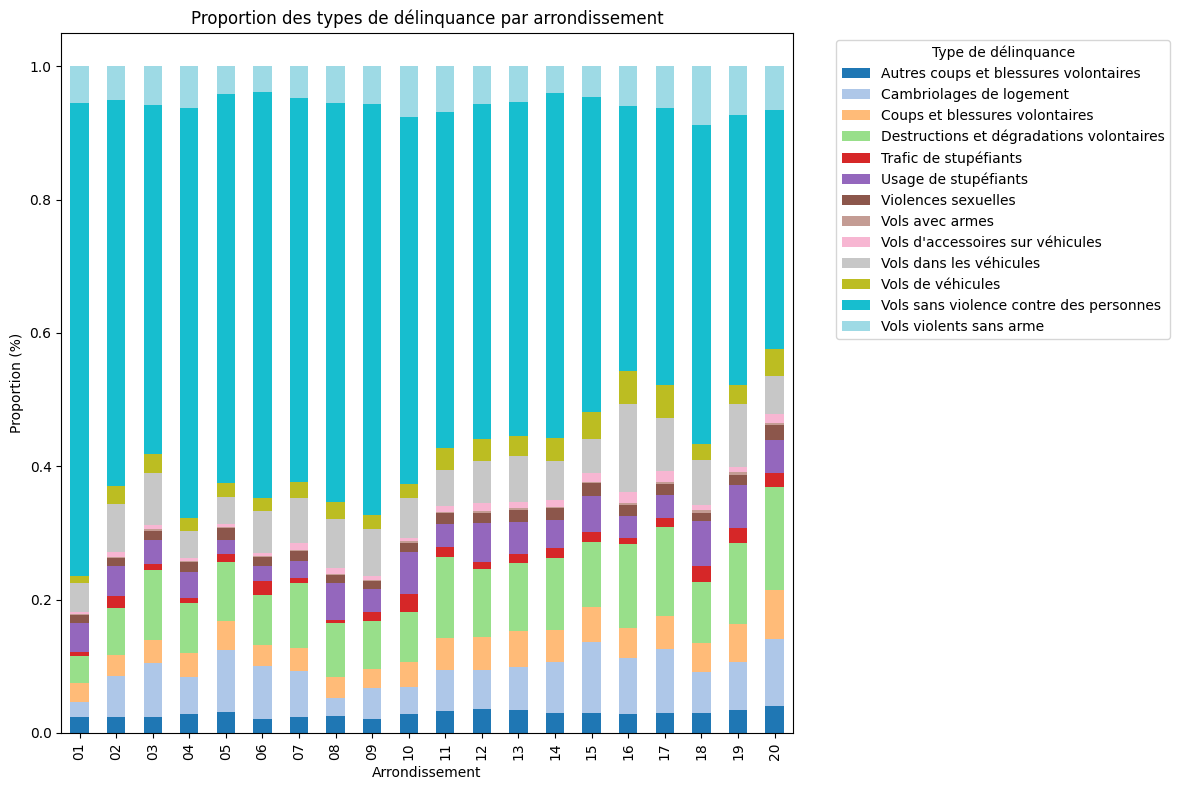

In [176]:
# Normalisation par arrondissement pour obtenir les proportions
df_delinquance_normalized = df_delinquance.copy()
df_delinquance_normalized['taux_normalise'] = df_delinquance_normalized.groupby('arrondissement')['tauxpourmille'].transform(lambda x: x / x.sum())

# Groupement des données par arrondissement et type de crime
grouped_data = df_delinquance_normalized.groupby(['arrondissement', 'classe'])['taux_normalise'].sum().unstack()

# Tracé du graphique 
ax = grouped_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    colormap='tab20',
    title="Proportion des types de délinquance par arrondissement"
)

plt.xlabel("Arrondissement")
plt.ylabel("Proportion (%)")
plt.legend(title="Type de délinquance", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Ce graphique représente la proportion des différents types de délinquance par arrondissement à Paris, exprimée en pourcentage. Il met en évidence une forte dominance des vols sans violence contre les personnes (en bleu clair), présents de manière significative dans tous les arrondissements